# Exploratory Data Analysis- PubMed Trending Articles

The goal of this study is to analyze the features relevant to article appearance and position in PubMed Trending pages. 

## Importing packages

In [71]:
import re
import requests
import bs4
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from pattern.text.en import singularize

import pyodbc
from sqlalchemy import create_engine
import urllib

import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Scraping Data from PubMed

In [3]:
## Web Scrapping PubMed Trending Pages 

all_contents = []
id_pattern = re.compile(r'data-article-id="\d*"')
pmid_pattern = re.compile(r'\n?PMID:\s*\d{8}')
year_pattern = re.compile(r'\.\s+\d{4}\.\n')
name_pattern = re.compile(r'^\n*.*\n?\.?\n')
jour_pattern = re.compile(r'\n.*\.\s*\d{4}\.\n*PMID:')
access_pattern = re.compile(r'Free\s*article\.|Free\s*PMC\s*article\.', re.I)
pub_pattern = re.compile(r'\D\n.*\D$')

for page in range(1, 6):
    # Web scrapping pubMed Trending Pages
    r = requests.get(f"https://pubmed.ncbi.nlm.nih.gov/trending/?size=200&page={page}", allow_redirects=True)
    try:
        r.raise_for_status()
    except Exception as exc:
        print('There was a problem: %s' % (exc))

    # Creating an PubMed Trending html file.
    with open(f"PubMed_Trending_Page{page}.html", 'wb') as file:
        for chunk in r.iter_content(1000000):
            file.write(chunk)

    # Parsing html for PubMed Trending Data
    with open(f"PubMed_Trending_Page{page}.html", encoding='utf-8') as data:
        dataSoup = bs4.BeautifulSoup(data, 'html.parser')
        all_elems = dataSoup.find_all(class_='docsum-content')
        contents = []

        for items in all_elems:
            id_match = re.findall(id_pattern, str(items))
            years = re.findall(year_pattern, items.text.lstrip().rstrip('.'))
            names = re.findall(name_pattern, items.text.lstrip().rstrip())
            pmid = re.findall(pmid_pattern, items.text.lstrip().rstrip())
            journals = re.findall(jour_pattern, items.text.lstrip().rstrip())
            pub = re.findall(pub_pattern, items.text.lstrip().rstrip())
            access = re.findall(access_pattern, items.text.lstrip().rstrip())
            for id in id_match:
                num_id = [id[18:-1]]
                contents = contents + num_id
                if pmid:
                    for pid in pmid:
                        pid = [pid.replace('PMID: ', '')]
                        contents = contents + pid
                else:
                    contents.append('')
                if years:
                    contents = contents + years
                else:
                    contents.append('')
                if names:
                    contents = contents + names
                else:
                    contents.append('')
                if journals:
                    for journal in journals:
                        journal = journal.replace('.\nPMID:', '')
                        jour = journal.split('.')
                        jour.pop()
                        contents = contents + jour
                else:
                    contents.append('')
                if access:
                    contents = contents + access
                else:
                    contents.append('')
                if pub:
                    contents = contents + pub
                else:
                    contents.append('')
        for content in contents:
            all_contents.append(content.replace("\n", '').lstrip('. ').rstrip('.'))
trend_format = [all_contents[x:x + 7] for x in range(0, len(all_contents), 7)]
trend_cols = ['ArticleID', 'PMID', 'Year', 'Title', 'Journal', 'Access', 'Details']

# Writing PubMed Trending Data to CSV file.
with open("PubMed_Trending_Data.csv", 'w', newline='', encoding='utf-8') as trending_csv:
    write = csv.writer(trending_csv)
    write.writerow(trend_cols)
    write.writerows(trend_format)

In [4]:
## Web Scrapping PubMed Journal List 
r = requests.get(f"https://ftp.ncbi.nih.gov/pubmed/J_Medline.txt", allow_redirects=True)
try:
    r.raise_for_status()
except Exception as exc:
    print('There was a problem: %s' % (exc))

# Creating text file
with open(f"PubMed_Journal_List.txt", 'wb') as ref_file:
    for chunk in r.iter_content(1000000):
        ref_file.write(chunk)

# Parsing Journal List text file
with open(f"PubMed_Journal_List.txt", 'r') as jour_file:
    journals = jour_file.readlines()
    pattern = re.compile(r':.*')
    matches = []
    for lines in journals:
        lines = lines.rstrip()
        match = re.findall(pattern, lines)
        for value in match:
            if match:
                matches.append(value.replace(':', '').lstrip())
            else:
                matches.append('')
    data_format = [matches[x:x + 7] for x in range(0, len(matches), 7)]
journal_cols = ['JrId', 'JournalTitle', 'MedAbbr', 'ISSN(Print)', 'ISSN(Online)', 'IsoAbbr', 'NlmId']

# Writing Journal List Data to CSV file.
with open("PubMed_Journal_Data.csv", 'w', newline='', encoding='utf-8') as journal_csv:
    write = csv.writer(journal_csv)
    write.writerow(journal_cols)
    write.writerows(data_format)

## Data Cleaning 

In [5]:
# Reading PubMed Trending Data to pandas dataframe 
df_trending = pd.read_csv(".\\PubMed_Trending_Data.csv")

In [6]:
# Reading PubMed Journal Data to pandas dataframe
df_journal = pd.read_csv(".\\PubMed_Journal_data.csv")

In [7]:
# connecting to MS SQL server
def connection(driver, server):
    connection = pyodbc.connect(driver=driver, server=server,trusted_connection='yes',autocommit=True)
    return connection 

In [8]:
conn =connection('{SQL Server}','LAPTOP-BFPVJ531\SQLEXPRESS')

In [9]:
cursor = conn.cursor()

In [10]:
cursor.execute("""IF NOT EXISTS(
     SELECT name FROM master.dbo.sysdatabases 
     WHERE name = 'PubMed'
    )
CREATE DATABASE PubMed """)

In [11]:
# Connecting to MS SQL and database
def engine(driver, server,database):
    cnxn = urllib.parse.quote_plus(f"driver={driver}; server={server};database={database};trusted_connection=yes")
    engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(cnxn))
    return engine
    

In [12]:
engine = engine('{SQL Server}','LAPTOP-BFPVJ531\SQLEXPRESS','PubMed')

In [13]:
# Exporting PubMed Trending df to SQL
df_trending.to_sql('PubMed_Trending',con=engine,schema='dbo',if_exists='replace',index=False)


In [14]:
# Exporting PubMed Journal df to SQL
df_journal.to_sql('PubMed_Journal',con=engine,schema='dbo',if_exists='replace',index=False)

In [15]:
dataset = engine.execute('SELECT * FROM PubMed_Trending')
dataset.fetchall()

[(5139340, 35139340.0, 2022.0, 'SARS-CoV-2 vaccination induces immunological T cell memory able to cross-recognize variants from Alpha to Omicron', 'Cell', 'Free PMC article', None),
 (5135310, 35135310.0, 2022.0, 'Effectiveness of ivermectin-based multidrug therapy in severely hypoxic, ambulatory COVID-19 patients', 'Future Microbiol', None, None),
 (5132264, 35132264.0, 2022.0, 'Activity-dependent spinal cord neuromodulation rapidly restores trunk and leg motor functions after complete paralysis', 'Nat Med', None, None),
 (5143257, 35143257.0, 2022.0, 'Highly enriched BEND3 prevents the premature activation of bivalent genes during differentiation', 'Science', None, None),
 (5001385, 15001385.0, 2004.0, 'Self-inflicted cesarean section with maternal and fetal survival', 'Int J Gynaecol Obstet', None, None),
 (5421604, 25421604.0, 2014.0, 'The prevalence of trimetazidine use in athletes in Poland: excretion study after oral drug administration', 'Drug Test Anal', None, None),
 (513935

In [16]:
# Adding PositionID column in PubMed Trending Table
dataset = engine.execute('ALTER TABLE [dbo].[PubMed_Trending] ADD PositionID int IDENTITY')

In [17]:
# Assigning PK constraint to JrID in PubMed Trending Table. 
dataset = engine.execute('ALTER TABLE [dbo].[PubMed_Trending] ADD CONSTRAINT PK_PosID PRIMARY KEY (PositionID)')

In [18]:
# Creating JrId column in PubMed_Trending Table 
dataset = engine.execute('ALTER TABLE [dbo].[PubMed_Trending] ADD [JrID] int')

In [19]:
# Changing JrID column in PubMed Journal Table to NOT NULL. 
dataset = engine.execute('ALTER TABLE [dbo].[PubMed_Journal] ALTER COLUMN JrID INT NOT NULL')

In [20]:
# Assigning PK constraint to JrID in PubMed_Journal Table. 
dataset = engine.execute('ALTER TABLE [dbo].[PubMed_Journal] ADD CONSTRAINT PK_JrId PRIMARY KEY (JrId)')

In [21]:
# Inserting JrID into JrID column in PubMed Trending using PubMed Journal JrID. 
dataset = engine.execute('UPDATE PubMed_Trending SET PubMed_Trending.JrID = PubMed_Journal.JrId FROM PubMed_Trending INNER JOIN PubMed_Journal ON PubMed_Journal.MedAbbr = PubMed_Trending.Journal WHERE PubMed_Trending.JrID IS NULL')

In [22]:
# Setting JrID in PubMed Trending Table as FK 
dataset = engine.execute('ALTER TABLE PubMed_Trending ADD CONSTRAINT FK_JrID FOREIGN KEY (JrID) REFERENCES PubMed_Journal (JrId)')

In [23]:
# Setting PMID and Year column to numeric type. 
dataset = engine.execute('ALTER TABLE PubMed_Trending ALTER COLUMN PMID bigint')
dataset = engine.execute('ALTER TABLE PubMed_Trending ALTER COLUMN Year int')

In [24]:
# Cleaning null values in Access Column in PubMed Trending.
dataset = engine.execute("""UPDATE PubMed_Trending SET Access = 'Restricted' WHERE Access IS NULL""")

In [25]:
# Reading PubMed Trending table to pandas df
df = pd.read_sql_table('PubMed_Trending',engine,coerce_float=False)

In [26]:
# Converting columns from float to integer

df.head()
df['Year'] = df['Year'].astype('Int64')
df['JrID'] = df['JrID'].astype('Int64')
df['PMID'] = df['PMID'].astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleID   1000 non-null   int64 
 1   PMID        984 non-null    Int64 
 2   Year        999 non-null    Int64 
 3   Title       1000 non-null   object
 4   Journal     999 non-null    object
 5   Access      1000 non-null   object
 6   Details     119 non-null    object
 7   PositionID  1000 non-null   int64 
 8   JrID        999 non-null    Int64 
dtypes: Int64(3), int64(2), object(4)
memory usage: 73.4+ KB


In [67]:
df.head()

,ArticleID,PMID,Year,Title,Journal,Access,Details,PositionID,JrID
0,5139340,35139340,2022,SARS-CoV-2 vaccination induces immunological T cell memory able to cross-recognize variants from Alpha to Omicron,Cell,Free PMC article,None,1,2830
1,5135310,35135310,2022,"Effectiveness of ivermectin-based multidrug therapy in severely hypoxic, ambulatory COVID-19 patients",Future Microbiol,Restricted,None,2,33506
2,5132264,35132264,2022,Activity-dependent spinal cord neuromodulation rapidly restores trunk and leg motor functions after complete paralysis,Nat Med,Restricted,None,3,8791
3,5143257,35143257,2022,Highly enriched BEND3 prevents the premature activation of bivalent genes during differentiation,Science,Restricted,None,4,7473
4,5001385,15001385,2004,Self-inflicted cesarean section with maternal and fetal survival,Int J Gynaecol Obstet,Restricted,None,5,3342


## EDA

<AxesSubplot:>

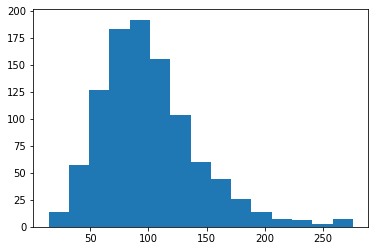

In [28]:
# Distribution of character length. 
df['Title'].str.len().hist(grid=False,bins=15)

<AxesSubplot:>

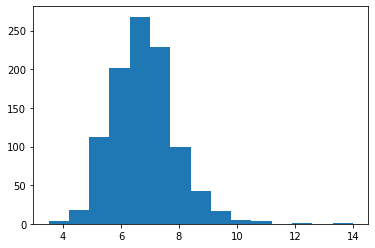

In [29]:
# Distribution of average character length in article titles 
df['Title'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(grid=False,bins=15)


In [59]:
# Extracting Keywords
stop=set(stopwords.words('english'))
# all_words = []
titles = df['Title'].str.split()
titles=titles.values.tolist()
words = [singularize(word.lower()) for i in titles for word in i]
all_keywords = Counter(words)
most = all_keywords.most_common()
keywords, counts = [],[]
for key, cnt in most:
    if key.lower() not in stop:
        keywords.append(key)
        counts.append(cnt)

# norm_values = [float(i)/max(counts) for i in counts]


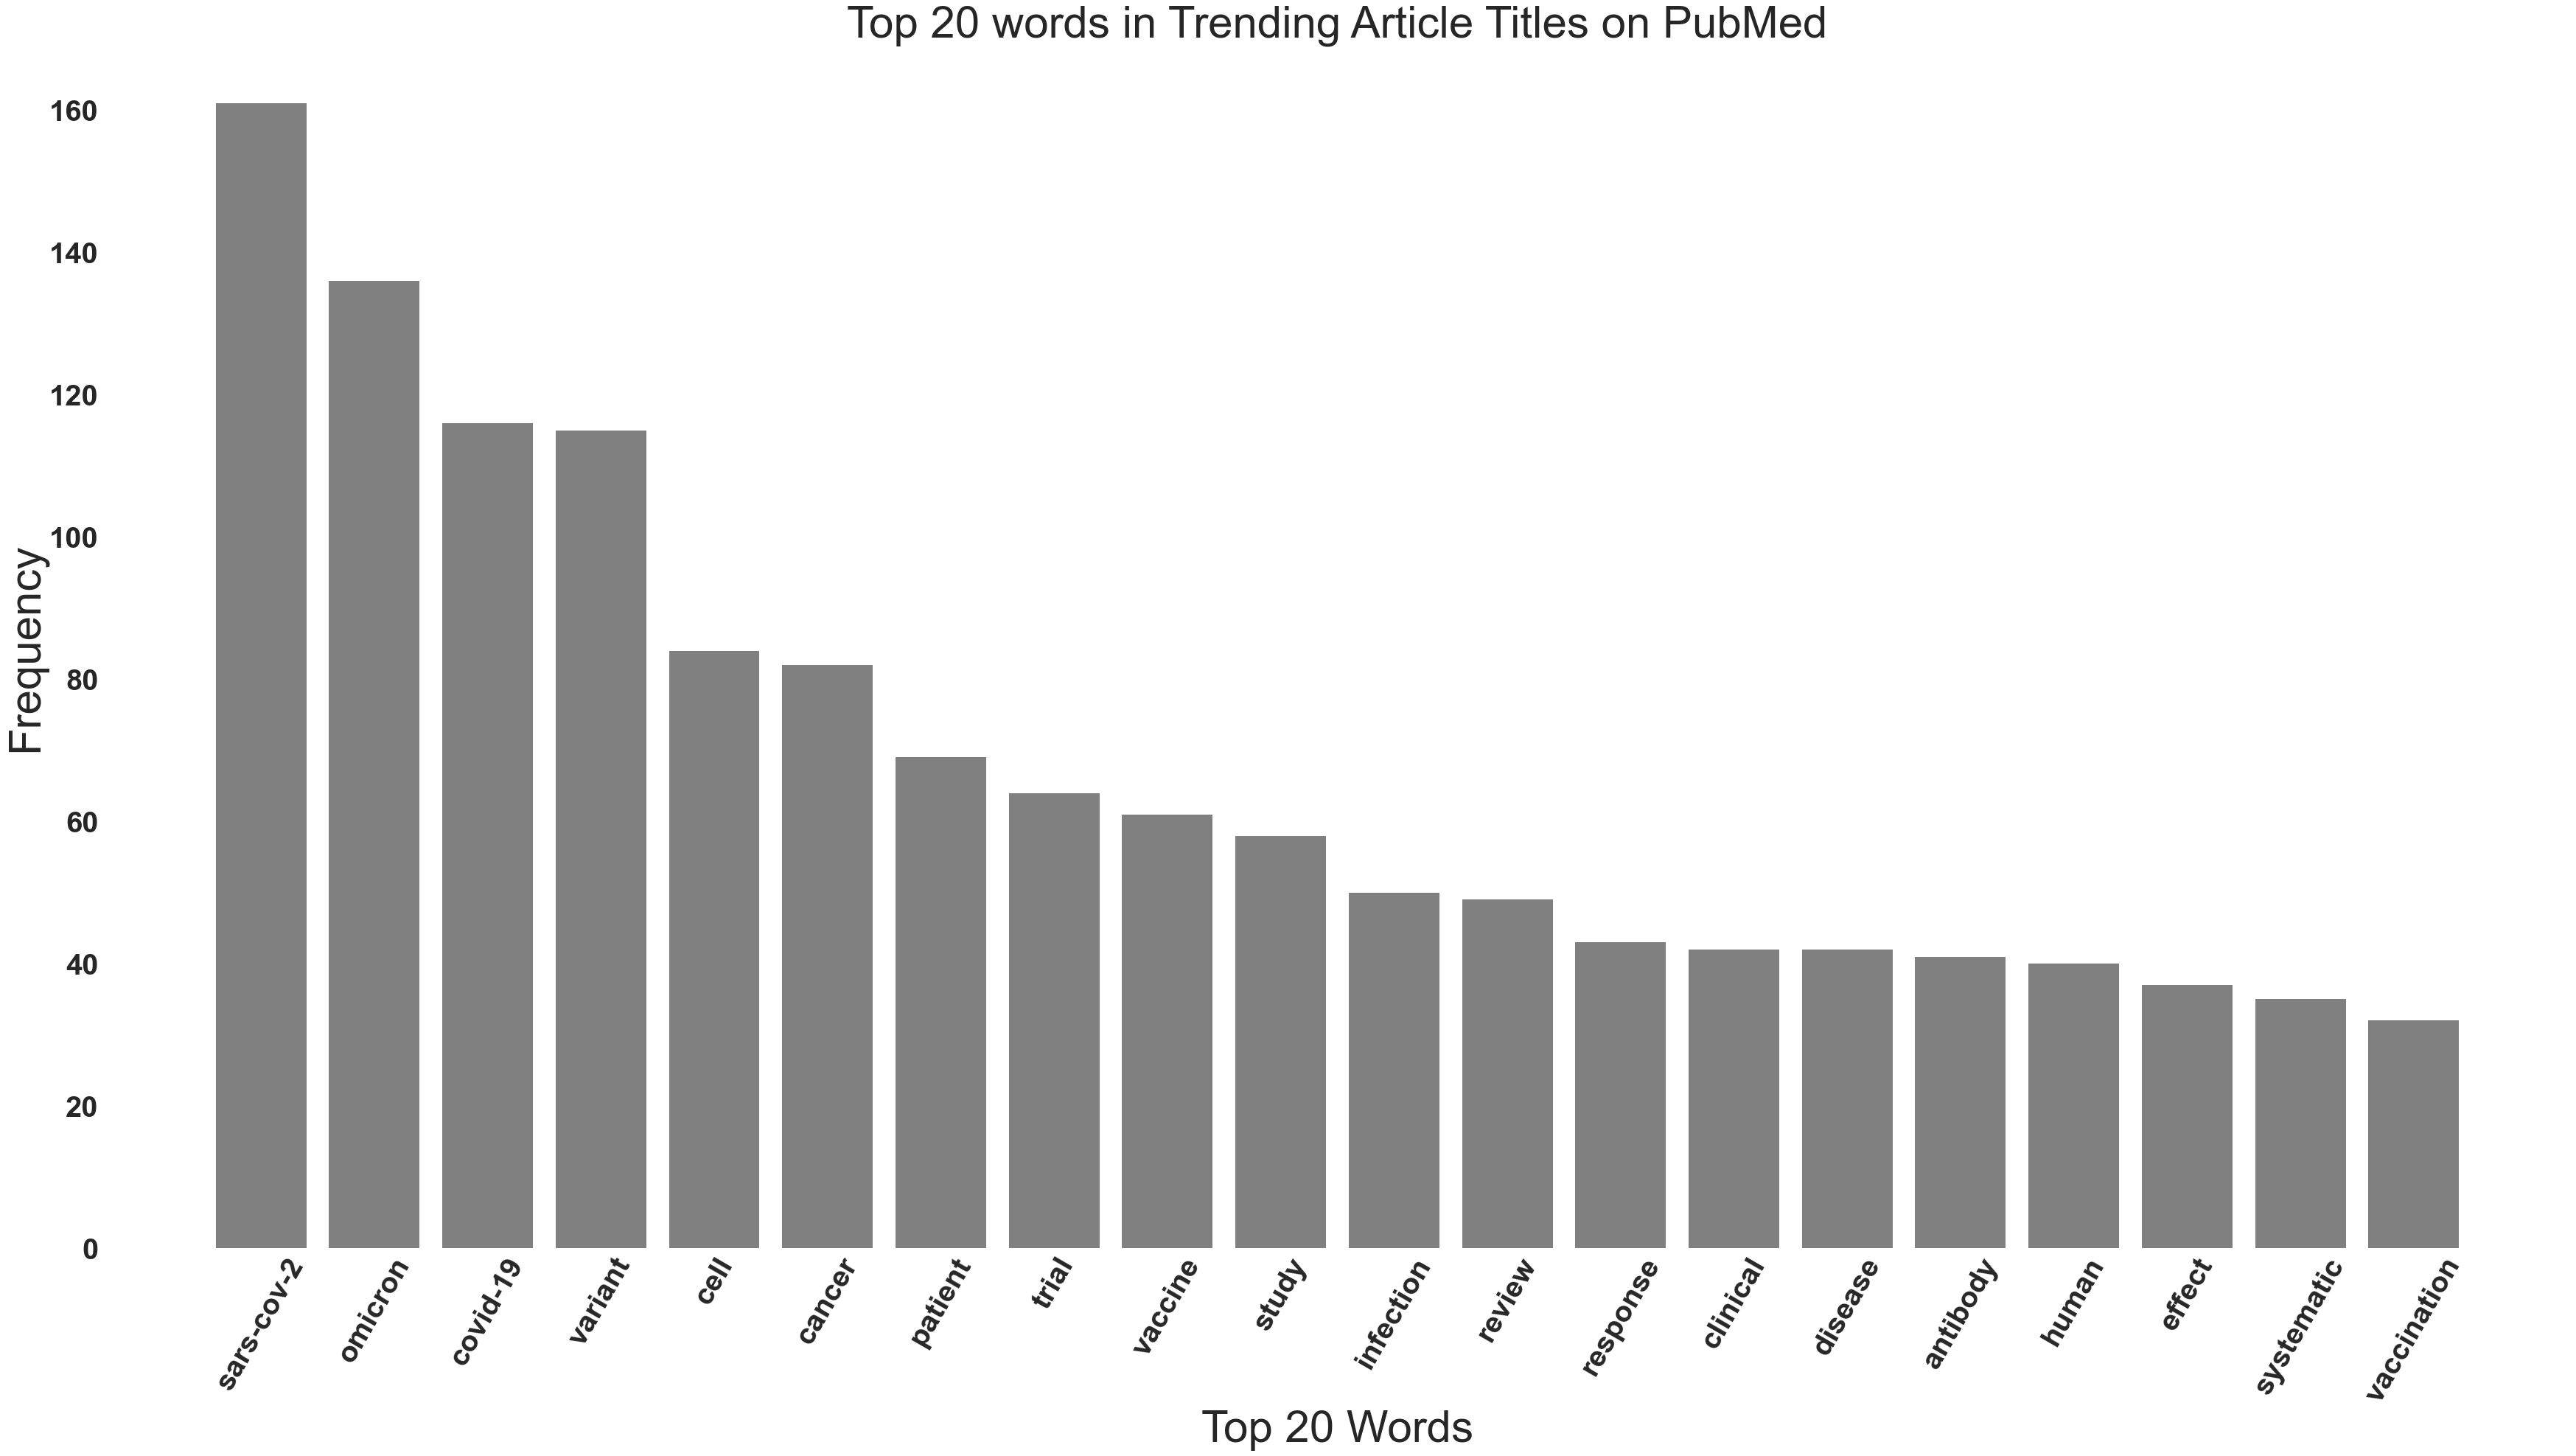

In [84]:
# Frequent words in trending article titles. 
fig, ax = plt.subplots(1, 1, figsize=(60,30))
ax.bar(keywords[:20], counts[:20], color='grey')
ax.set_title('Top 20 words in Trending Article Titles on PubMed', fontsize=60)
ax.set_xlabel(xlabel='Top 20 Words', fontsize=60)
ax.set_ylabel(ylabel='Frequency', fontsize=60)
plt.xticks(rotation=60)
plt.setp(ax.get_xticklabels(), fontsize=40, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=40, fontweight="bold" ) 
ax.set_facecolor('white')
plt.grid(False)
plt.show()

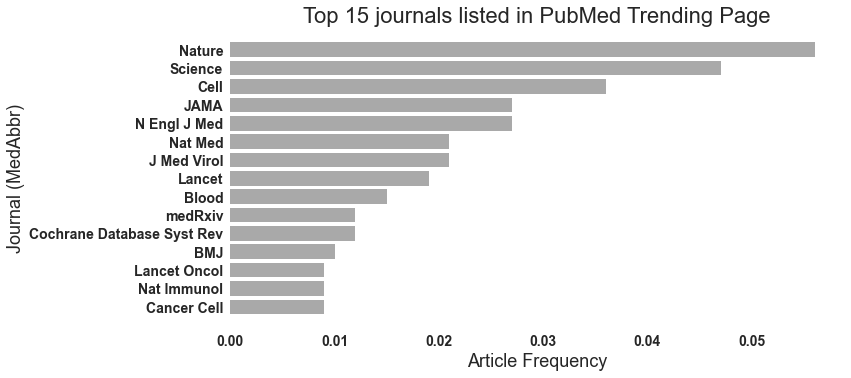

In [31]:
# Top Journal Bar Chart 
journalCount = df['Journal'].value_counts(normalize=True)
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1,figsize=plt.figaspect(0.5))
ax.barh(journalCount[:15].index, journalCount[:15].values, color='darkgrey')
# Setting chart elements 
ax.set_title('Top 15 journals listed in PubMed Trending Page', fontsize=22)
ax.set_xlabel(xlabel='Article Frequency', fontsize=18)
ax.set_ylabel(ylabel='Journal (MedAbbr)', fontsize=18)
ax.set_facecolor('white')
# plt.xticks(rotation=270)
plt.setp(ax.get_xticklabels(), fontsize=14, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=14, fontweight="bold" )
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()



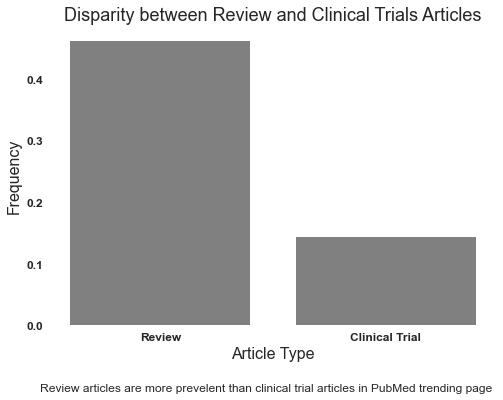

In [34]:
# Visualization of article type 
art_intent = df['Details'].value_counts(normalize=True)
plt.style.use('seaborn')

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1)
ax.bar(art_intent.index[0:3:2],art_intent.values[0:3:2], color='grey')
ax.set_title('Disparity between Review and Clinical Trials Articles',fontsize=18)
ax.set_xlabel(xlabel='Article Type',fontsize=16)
ax.set_ylabel(ylabel='Frequency',fontsize=16 )
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=12, fontweight="bold" ) 
txt="Review articles are more prevelent than clinical trial articles in PubMed trending page"
plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=12)
ax.set_facecolor('white')
plt.grid(False)
plt.show()

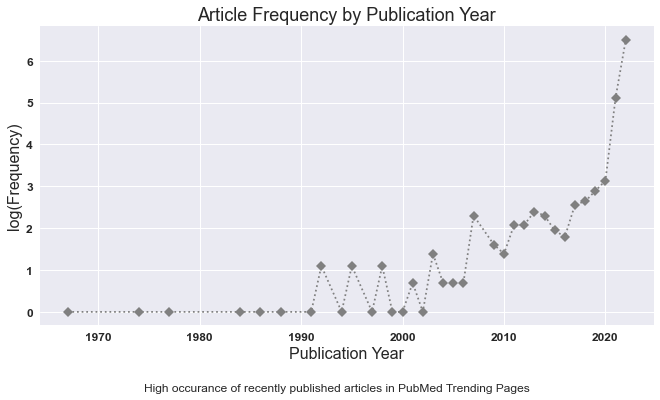

In [35]:
# trend of article freguency by publication year 
yearlyCount = df.groupby(['Year']).Year.count()
values = []
for value in yearlyCount.values:
    values.append(np.log(value))
year = yearlyCount.index.to_list()

# Creating line plot
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1,figsize=plt.figaspect(0.5))
ax.plot(year,values, 'r:D',color='grey')


# Setting chart elements 
ax.set_title('Article Frequency by Publication Year', fontsize=18)
ax.set_xlabel(xlabel='Publication Year', fontsize=16)
ax.set_ylabel(ylabel='log(Frequency)', fontsize=16)

plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=12, fontweight="bold" )
# plt.grid(False)
txt="High occurance of recently published articles in PubMed Trending Pages"
plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


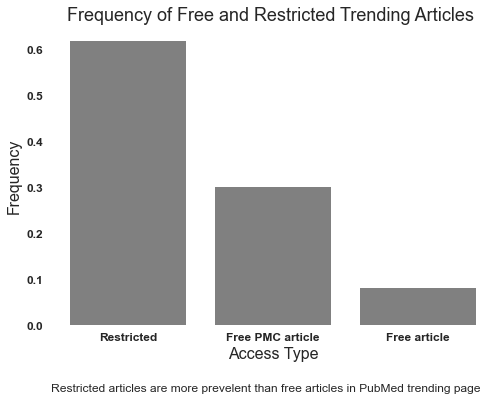

In [70]:
# frequency of access of trending articles 
access = df['Access'].value_counts(normalize=True)
plt.style.use('seaborn')

plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1)
ax.bar(access.index,access.values, color='grey')
ax.set_title('Frequency of Free and Restricted Trending Articles ',fontsize=18)
ax.set_xlabel(xlabel='Access Type',fontsize=16)
ax.set_ylabel(ylabel='Frequency',fontsize=16 )
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=12, fontweight="bold" ) 
txt=" articles are more prevelent than free articles in PubMed trending page"
plt.figtext(0.5, -0.04, txt, wrap=True, horizontalalignment='center', fontsize=12)
ax.set_facecolor('white')
plt.grid(False)
plt.show()

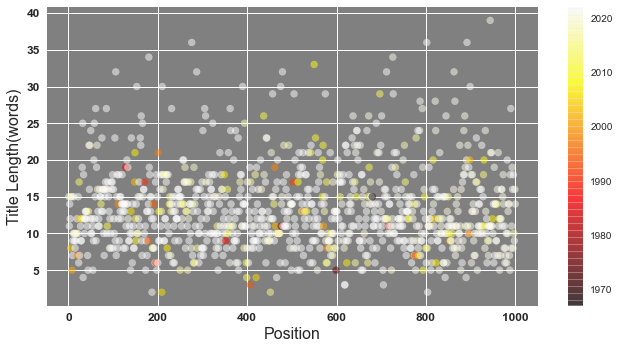

In [85]:
# any association between title length and location of trending articles

article = df['Title'].str.split()
length = []
df['Year'].fillna(2021, inplace=True)
for words in article:
    length.append(len(words))
fig, ax = plt.subplots(figsize=plt.figaspect(0.5))
sc = ax.scatter(df['PositionID'], length, c=df['Year'], cmap='hot', alpha=0.5,)
ax.set_xlabel('Position',fontsize=16)
ax.set_ylabel('Title Length(words)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold" ) # horizontalalignment="left"
plt.setp(ax.get_yticklabels(), fontsize=12, fontweight="bold" ) 
ax.set_facecolor('grey')
fig.colorbar(sc)
plt.show()
